In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

In [2]:
# Plotting defaults
font_manager.fontManager.ttflist.extend(
    font_manager.createFontList(
        font_manager.findSystemFonts(fontpaths="/users/amtseng/modules/fonts")
    )
)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

/users/amtseng/miniconda3/envs/tfmodisco-mini/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  after removing the cwd from sys.path.


### Get best model definitions

In [3]:
def collect_model_defs(
    tf, num_tasks, multitask_finetune_model_def_tsv,
    singletask_finetune_model_def_tsv
):
    """
    From the TSVs containing model statistics/definitions, extracts the
    following and returns them for the given TF:
        1. Model definition of the finetuned multi-task profile model, as
            (fold_num, run_num, epoch_num) (i.e. just the one best fold)
        2. Model definitions of the finetuned single-task profile models, as a
            list of (task_index, fold_num, run_num, epoch_num) (i.e. just the
            one best fold for each task)
    """
    # Finetuned multi-task model
    finetune_multitask_def = None
    with open(multitask_finetune_model_def_tsv, "r") as f:
        for line in f:
            tokens = line.strip().split("\t")
            if tokens[0] == tf and int(tokens[1]) == num_tasks - 1:
                assert finetune_multitask_def is None
                finetune_multitask_def = (
                    int(tokens[2]), int(tokens[3].split("/")[1]),
                    int(tokens[4].split("/")[1])
                )

    # Finetuned single-task models
    finetune_singletask_defs = []
    with open(singletask_finetune_model_def_tsv, "r") as f:
        for line in f:
            tokens = line.strip().split("\t")
            if tokens[0] == tf:
                finetune_singletask_defs.append((
                    int(tokens[1]), int(tokens[2]),
                    int(tokens[3].split("/")[1]), int(tokens[4].split("/")[1])
                ))
    assert len(finetune_singletask_defs) == num_tasks

    return finetune_multitask_def, finetune_singletask_defs

In [4]:
out_path = "/users/amtseng/tfmodisco/figures/performance_summary"
os.makedirs(out_path, exist_ok=True)

tf_names = [
    "E2F6", "FOXA2", "SPI1", "CEBPB", "MAX", "GABPA", "MAFK", "JUND", "NR3C1-reddytime", "REST"
]
tf_names_clean = tf_names[:]
tf_names_clean[8] = "NR3C1"

tf_num_tasks = {
    "E2F6": 2,
    "FOXA2": 4,
    "SPI1": 4,
    "CEBPB": 7,
    "MAX": 7,
    "GABPA": 9,
    "MAFK": 9,
    "JUND": 14,
    "NR3C1-reddytime": 16,
    "REST": 20
}

best_model_types = {
    "E2F6": list("MM"),
    "FOXA2": list("SSMM"),
    "SPI1": list("MSSS"),
    "CEBPB": list("MMMMSMM"),
    "MAX": list("MMSMMSS"),
    "GABPA": list("MMMSMMMMM"),
    "MAFK": list("MMMMMMMMM"),
    "JUND": list("SMMSMSSSSSSSMS"),
    "NR3C1-reddytime": list("MMMSMMSMMMMSMMMM"),
    "REST": list("MMMMMMMMMSMMSMMSMMMM")
}

### Import performance metrics

In [5]:
count_pears = {}
profile_jsd = {}
profile_nll = {}

for tf_name in tf_names:
    count_pears[tf_name] = []
    profile_jsd[tf_name] = []
    profile_nll[tf_name] = []
    
    for task_index in range(tf_num_tasks[tf_name]):
        if best_model_types[tf_name][task_index] == "M":
            perf_file = os.path.join(
                "/users/amtseng/tfmodisco/results/reports/model_performance/cache/",
                tf_name,
                "multitask_finetuned_tasks.h5",
            )
            with h5py.File(perf_file, "r") as f:
                count_pears[tf_name].append(f["count_pearson"][str(task_index)][()])
                profile_jsd[tf_name].append(np.mean(f["jsd"][str(task_index)][:]))
                profile_nll[tf_name].append(np.mean(f["nll"][str(task_index)][:]))
        else:
            perf_file = os.path.join(
                "/users/amtseng/tfmodisco/results/reports/model_performance/cache/",
                tf_name,
                "singletask_task%d_allfolds_finetuned.h5" % task_index,
            )
            with h5py.File(perf_file, "r") as f:
                count_pears[tf_name].append(f["count_pearson"]["10"][()])
                profile_jsd[tf_name].append(np.mean(f["jsd"]["10"][:]))
                profile_nll[tf_name].append(np.mean(f["nll"]["10"][:]))

### Construct plot

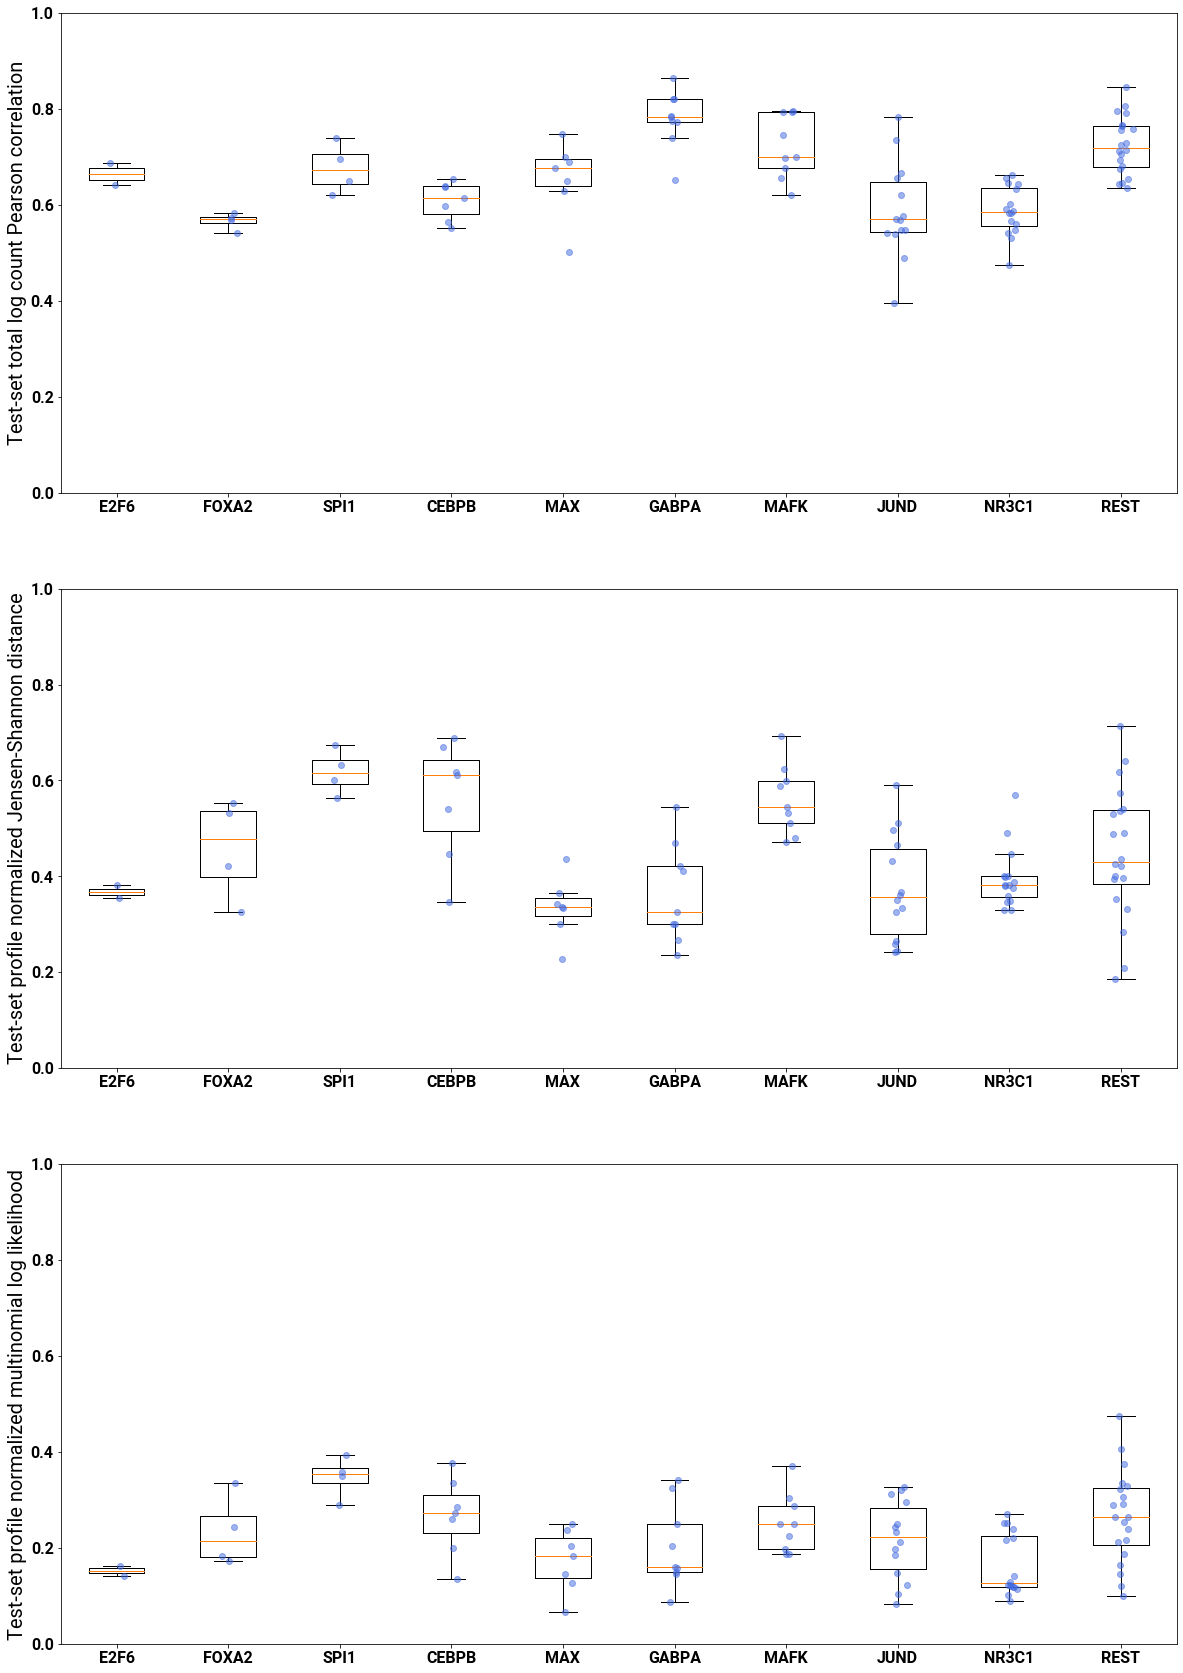

In [6]:
fig, ax = plt.subplots(nrows=3, figsize=(20, 30), sharey=True)

all_vals = [count_pears[tf_name] for tf_name in tf_names]
ax[0].boxplot(all_vals, showfliers=False, zorder=0)
for i, vals in enumerate(all_vals):
    x = np.random.normal(i + 1, 0.04, len(vals))
    ax[0].scatter(x, vals, alpha=0.5, color="royalblue", zorder=1)
ax[0].set_ylabel("Test-set total log count Pearson correlation")
ax[0].set_xticklabels(tf_names_clean)
ax[0].set_ylim(0, 1)

all_vals = [profile_jsd[tf_name] for tf_name in tf_names]
ax[1].boxplot(all_vals, showfliers=False, zorder=0)
for i, vals in enumerate(all_vals):
    x = np.random.normal(i + 1, 0.04, len(vals))
    ax[1].scatter(x, vals, alpha=0.5, color="royalblue", zorder=1)
ax[1].set_ylabel("Test-set profile normalized Jensen-Shannon distance")
ax[1].set_xticklabels(tf_names_clean)

all_vals = [profile_nll[tf_name] for tf_name in tf_names]
ax[2].boxplot(all_vals, showfliers=False, zorder=0)
for i, vals in enumerate(all_vals):
    x = np.random.normal(i + 1, 0.04, len(vals))
    ax[2].scatter(x, vals, alpha=0.5, color="royalblue", zorder=1)
ax[2].set_ylabel("Test-set profile normalized multinomial log likelihood")
ax[2].set_xticklabels(tf_names_clean)

plt.savefig(
    os.path.join(out_path, "performance_summary.svg"),
    format="svg"
)